In [2]:
%run imports.ipynb
%run '08222019_functions.ipynb'
import allel
import zarr
import pandas as pd
import petl as etl
import numpy as np
import matplotlib.pyplot as plt
import dask.array as da
import seaborn as sns
from IPython.display import Image
palette = sns.color_palette()

In [3]:
from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=30)
cluster

In [4]:
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://10.33.122.103:46431 Dashboard: /user/carlo%20mariade%20marco1/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
calldata_out= zarr.open('../data/outgroup_alleles_phase2.zarr/')
calldata_biallel= zarr.open('../data/phase2_biallel_allele_count.zarr/')

In [6]:
an_col = 'BFcol', 'GNcol', 'CIcol', 'GHcol'
an_gam = 'GHgam', 'CMgam', 'BFgam', 'GNgam', 'GQgam'
an_fw = 'GM', 'GW'
out_species = ['arab', 'chri', 'epir', 'mela', 'meru', 'quad']

In [7]:
def count_alleles_pos(chrom, start, stop):
    df_samples = pd.read_csv("samples.meta.txt", sep="\t")
    pos_all = allel.SortedIndex(callset_biallel[chrom]["variants/POS"])
    loc = pos_all.locate_range(start,stop)
    gt = allel.GenotypeDaskArray(callset_biallel[chrom]['calldata/GT'])
    subpops = metadata.groupby('population').indices
    ac_subpops = allel.AlleleCountsChunkedTable(gt[loc].count_alleles_subpops(subpops))
    return ac_subpops

In [8]:
ac_3L_free = count_alleles_pos('3L', 18_000_000, 41_000_000)
ac_3L_free

<AlleleCountsChunkedTable shape=(5358122,) dtype=[('AOcol', '<i4', (2,)), ('BFcol', '<i4', (2,)), ('BFgam', '<i4', (2,)), ('CIcol', '<i4', (2,)), ('CMgam', '<i4', (2,)), ('FRgam', '<i4', (2,)), ('GAgam', '<i4', (2,)), ('GHcol', '<i4', (2,)), ('GHgam', '<i4', (2,)), ('GM', '<i4', (2,)), ('GNcol', '<i4', (2,)), ('GNgam', '<i4', (2,)), ('GQgam', '<i4', (2,)), ('GW', '<i4', (2,)), ('KE', '<i4', (2,)), ('UGgam', '<i4', (2,))]
   nbytes=654.1M
   values=builtins.dict>

In [9]:
loc = (allel.SortedIndex(callset_biallel['3L']["variants/POS"])).locate_range(18_000_000, 41_000_000)
loc

slice(2298737, 7656859, None)

In [10]:
ac_out_3L_free = {pop: calldata_out['3L'][pop][loc] for pop in out_species}

In [11]:
chromosomes = ['3L']

In [12]:
ac_cache = dict()

def load_ac(pop):
    if (pop) in ac_cache:
        return ac_cache[pop]
    else:
        if pop in out_species:
            ac = allel.AlleleCountsChunkedArray(ac_out_3L_free[pop])
        else:
            ac = ac_3L_free[pop]
            ac_cache[pop] = ac
        return ac
    
fourpop_cache = dict()

In [13]:
def f3_analysis(chroms, A, B, C, regions=None, blen=100000, plot=False, ax=None):
    
    
    
    region_str = ",".join(["{0}_{1}".format(r.start, r.stop) for r in regions])
    
    key = (",".join(chroms), region_str, A, B, C, D, blen)
    if key in fourpop_cache:
        # re-use from cache
        d, d_se, d_z, d_vb, d_vj = fourpop_cache[key]
        
    else:
        # load allele counts
        aca = dask.array.vstack([load_ac(chrom, A)[region] for chrom, region in zip(chroms, regions)])
        acb = dask.array.vstack([load_ac(chrom, B)[region] for chrom, region in zip(chroms, regions)])
        acc = dask.array.vstack([load_ac(chrom, C)[region] for chrom, region in zip(chroms, regions)])
            
        # run D test
        d, d_se, d_z, d_vb, d_vj = allel.average_patterson_f3(aca, acb, acc, blen=blen)

        
        # cache for re-use
        fourpop_cache[key] = d, d_se, d_z, d_vb, d_vj
    
    return d, d_se, d_z, d_vb, d_vj

def f3_analyses(As, Bs, Cs, chroms=chromosomes, regions=None, blen=100000):
    
    if regions is None:
        regions = [slice(None)] * 4
    
    region_str = ",".join(["{0}_{1}".format(r.start, r.stop) for r in regions])
    # normalise inputs
    if not isinstance(chroms, (list, tuple)):
        chroms = [chroms]
    if not isinstance(As, (list, tuple)):
        As = [As]
    if not isinstance(Bs, (list, tuple)):
        Bs = [Bs]
    if not isinstance(Cs, (list, tuple)):
        Cs = [Cs]

        
    # setup output table
    tbl = [['chromosome', 'test', 'D', 'SE', 'Z']]

    for A in As:
        for B in Bs:
            if A != B:
                for C in Cs:
                    if C != B:
                            d, d_se, d_z, _, _ = f3_analysis(A, B, C, blen=blen)
                            test = '3L-free (15-41Mbp)  -  F3(%s, %s; %s)' % (A, B, C)
                            row = [test, d, d_se, d_z]
                            tbl += [row]

    # display results
    (etl
     .wrap(tbl)
     .interpolate('D', '%.3f')
     .interpolate('SE', '%.4f')
     .interpolate('Z', '%.1f')
     .displayall(index_header=False, 
                 tr_style=lambda row: 'background-color: %s' % ('#afa' if float(row.Z) > 5 else '#aaf' if float(row.Z) < -5 else 'white')))

In [14]:
#this is the function that perform the test
def f3_analysis(A, B, C, blen=100000, plot=False, ax=None):
    
    key = (A, B, C, blen)
    if key in fourpop_cache:
        # re-use from cache
        d, d_se, d_z, d_vb, d_vj = fourpop_cache[key]
        
    else:
        # load allele counts
        aca = load_ac(A)
        acb = load_ac(B)
        acc = load_ac(C)

        # run D test
        d, d_se, d_z, d_vb, d_vj = allel.average_patterson_f3(aca, acb, acc, blen=blen)
        
        # cache for re-use
        fourpop_cache[key] = d, d_se, d_z, d_vb, d_vj
    
    return d, d_se, d_z, d_vb, d_vj

#this is the function that give me to display multiple tests on a table
def f3_analyses(As, Bs, Cs, blen=100000):
    
    # normalise inputs
    if not isinstance(As, (list, tuple)):
        As = [As]
    if not isinstance(Bs, (list, tuple)):
        Bs = [Bs]
    if not isinstance(Cs, (list, tuple)):
        Cs = [Cs]
        
    # setup output table    
    tbl = [['test', 'D', 'SE', 'Z']]
    for A in As:
        for B in Bs:
            if A != B:
                for C in Cs:
                    if C != B:
                            d, d_se, d_z, _, _ = f3_analysis(A, B, C, blen=blen)
                            test = '3L-free (15-41Mbp)  -  F3(%s, %s; %s)' % (A, B, C)
                            row = [test, d, d_se, d_z]
                            tbl += [row]
    
    return tbl

def tbl_display(tbl):
        # display results
    (etl
     .wrap(tbl)
     .interpolate('D', '%.3f')
     .interpolate('SE', '%.4f')
     .interpolate('Z', '%.1f')
     .displayall(index_header=False, 
                 tr_style=lambda row: 'background-color: %s' % ('#afa' if float(row.Z) > 5 else '#aaf' if float(row.Z) < -5 else 'white')))
    

    
def tbl_f3_plot(table, title):
    # plot
    tbl = etl.wrap(table).sort('test')
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, tbl.nrows()*.2))
    
    ## First Plot - Bar Plot
    x = tbl.values('D').array()
    y = np.arange(tbl.nrows())
    ax1.axvline(0, color='r', lw=1)
    xerr = tbl.values('SE').array()
    ax1.errorbar(x, y, xerr=xerr, fmt='o', lw=1, color='k', mew=1, mfc='k')
    ax1.set_yticks(y)
    ylbls = ['%s; Z = %.1f' % (v.test, v.Z) for v in tbl.records()]
    ax1.set_yticklabels(ylbls)
    ax1.yaxis.tick_right()
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top')
    ax1.set_xlim(-.2,.2)
    ax1.set_ylim(-1, y.size)
    ax1.grid(axis='both', color='#dddddd')
    ax1.set_xlabel("Patterson's $D$ Barplot")
    fig.suptitle('%s' % (title), y=1.02, fontsize=16)

    ## Second plot - Heatmap
    results = etl.todataframe(tbl)
    df1 = results[['test', 'D','Z']].round(2)
    heatmap1_data = pd.pivot_table(df1, values='Z', 
                     index=['test'], 
                     columns='D')
    lm = sns.heatmap(heatmap1_data, cmap="RdBu", vmin=15, vmax=-15, annot=True)
    ax2 = lm.axes
    ax2.set_xlim(-.7)
    ax2.set_ylim(40.4)
    ax2.xaxis.set_label_position('top')
    ax2.xaxis.tick_top()
    plt.xticks(rotation=70)
    ax2.set_xlabel("Patterson's $D$ Heatmap")
    ax2.invert_yaxis()
    plt.text(1.02, 0.5, 'Z-score', {'fontsize': 15},
             horizontalalignment='left',
             verticalalignment='center',
             rotation=90,
             clip_on=False,
             transform=plt.gca().transAxes)

    ax2.grid(False, 'major')
    ax2.grid(True, 'minor')
    ax2.set_yticks([t - 0.5 for t in ax2.get_yticks()], minor=True)
    sns.despine()
    fig.tight_layout()
    plt.show()  

In [23]:
A = an_col
B = an_fw
C = an_gam
f3_test = f3_analyses(A, B, C)


NameError: name 'ac_3L_free' is not defined

In [12]:
tbl_display(f3_test)

NameError: name 'f3_test' is not defined

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


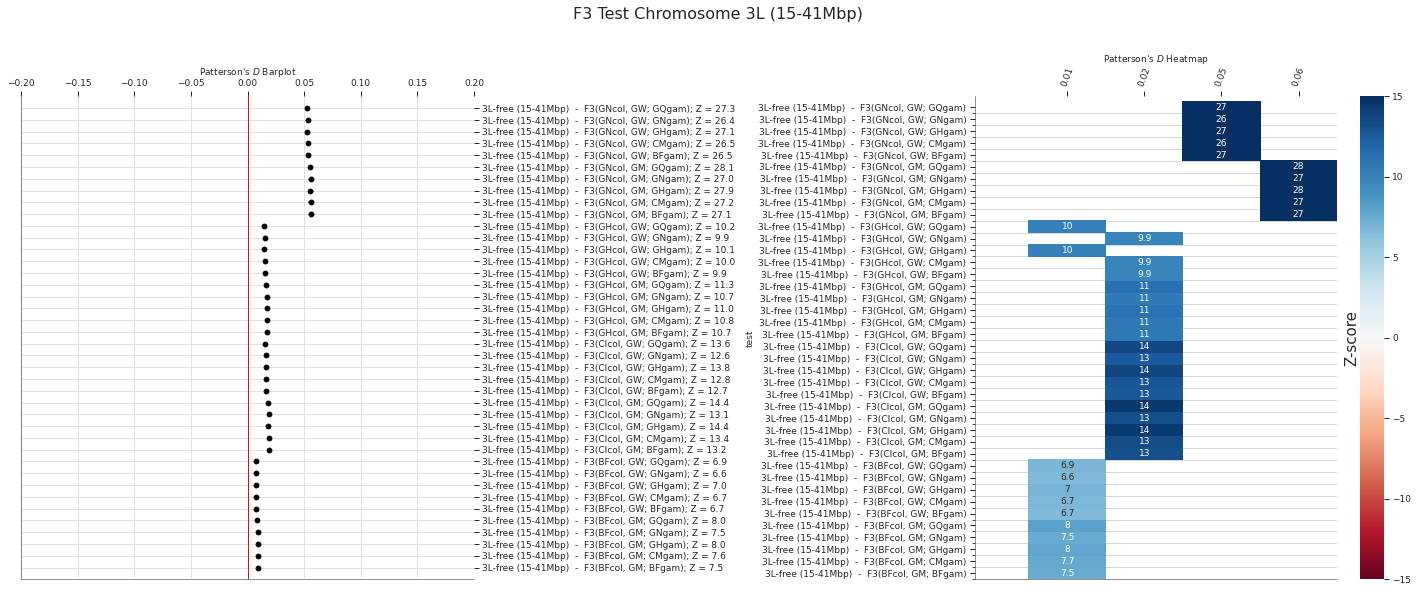

In [18]:
tbl_d_plot(f3_test, 'F3 Test Chromosome 3L (15-41Mbp)')

-------

In [19]:
A = an_fw
B = an_col
C = an_gam
f3_test = f3_analyses(A, B, C)

In [20]:
tbl_display(f3_test)

test,D,SE,Z
"3L-free (15-41Mbp) - F3(GM, BFcol; GHgam)",0.014,0.0010,14.2
"3L-free (15-41Mbp) - F3(GM, BFcol; CMgam)",0.014,0.0010,14.7
"3L-free (15-41Mbp) - F3(GM, BFcol; BFgam)",0.014,0.0009,14.8
"3L-free (15-41Mbp) - F3(GM, BFcol; GNgam)",0.014,0.0009,14.9
"3L-free (15-41Mbp) - F3(GM, BFcol; GQgam)",0.015,0.0010,14.2
"3L-free (15-41Mbp) - F3(GM, GNcol; GHgam)",0.010,0.0006,16.7
"3L-free (15-41Mbp) - F3(GM, GNcol; CMgam)",0.009,0.0006,15.4
"3L-free (15-41Mbp) - F3(GM, GNcol; BFgam)",0.009,0.0006,15.1
"3L-free (15-41Mbp) - F3(GM, GNcol; GNgam)",0.009,0.0006,15.0
"3L-free (15-41Mbp) - F3(GM, GNcol; GQgam)",0.010,0.0006,18.1


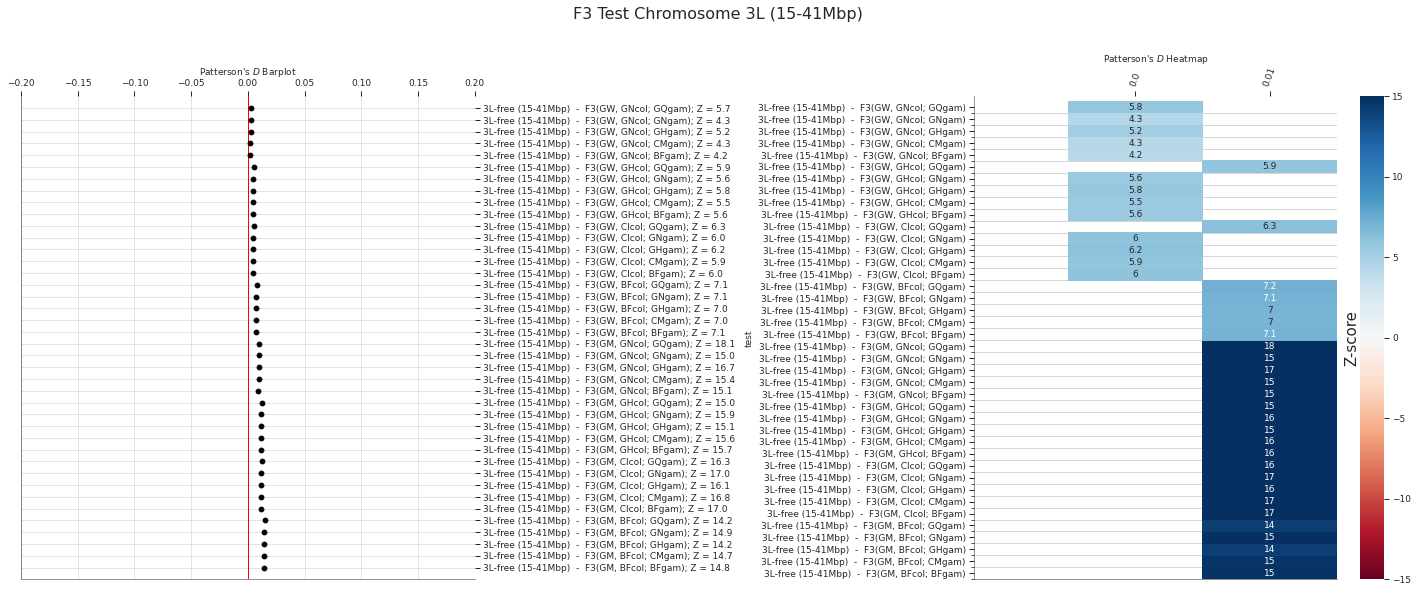

In [21]:
tbl_d_plot(f3_test, 'F3 Test Chromosome 3L (15-41Mbp)')

-------------------------------------

In [22]:
A = an_gam
B = an_col
C = an_fw
f3_test = f3_analyses(A, B, C)

In [23]:
tbl_display(f3_test)

test,D,SE,Z
"3L-free (15-41Mbp) - F3(GHgam, BFcol; GM)",0.021,0.0015,13.9
"3L-free (15-41Mbp) - F3(GHgam, BFcol; GW)",0.022,0.0016,14.1
"3L-free (15-41Mbp) - F3(GHgam, GNcol; GM)",0.025,0.0022,11.6
"3L-free (15-41Mbp) - F3(GHgam, GNcol; GW)",0.027,0.0023,11.8
"3L-free (15-41Mbp) - F3(GHgam, CIcol; GM)",0.023,0.0017,13.7
"3L-free (15-41Mbp) - F3(GHgam, CIcol; GW)",0.025,0.0018,13.8
"3L-free (15-41Mbp) - F3(GHgam, GHcol; GM)",0.023,0.0016,14.1
"3L-free (15-41Mbp) - F3(GHgam, GHcol; GW)",0.025,0.0018,14.2
"3L-free (15-41Mbp) - F3(CMgam, BFcol; GM)",0.018,0.0015,12.1
"3L-free (15-41Mbp) - F3(CMgam, BFcol; GW)",0.020,0.0016,12.3


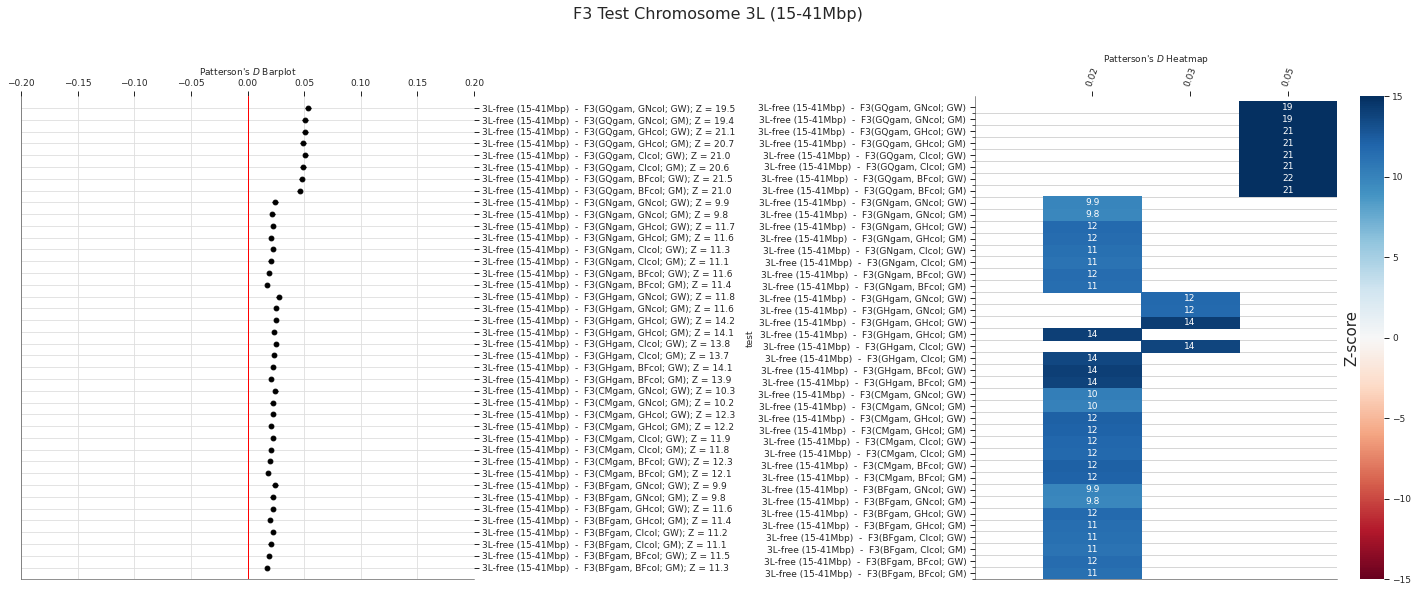

In [24]:
tbl_d_plot(f3_test, 'F3 Test Chromosome 3L (15-41Mbp)')

-----------------------------

In [25]:
A = an_col
B = an_gam
C = an_fw
f3_test = f3_analyses(A, B, C)

In [26]:
tbl_display(f3_test)

test,D,SE,Z
"3L-free (15-41Mbp) - F3(BFcol, GHgam; GM)",0.009,0.0012,8.0
"3L-free (15-41Mbp) - F3(BFcol, GHgam; GW)",0.007,0.0011,7.0
"3L-free (15-41Mbp) - F3(BFcol, CMgam; GM)",0.009,0.0012,7.6
"3L-free (15-41Mbp) - F3(BFcol, CMgam; GW)",0.008,0.0011,6.7
"3L-free (15-41Mbp) - F3(BFcol, BFgam; GM)",0.010,0.0013,7.5
"3L-free (15-41Mbp) - F3(BFcol, BFgam; GW)",0.008,0.0012,6.7
"3L-free (15-41Mbp) - F3(BFcol, GNgam; GM)",0.010,0.0013,7.5
"3L-free (15-41Mbp) - F3(BFcol, GNgam; GW)",0.008,0.0012,6.6
"3L-free (15-41Mbp) - F3(BFcol, GQgam; GM)",0.009,0.0011,8.0
"3L-free (15-41Mbp) - F3(BFcol, GQgam; GW)",0.007,0.0010,6.9


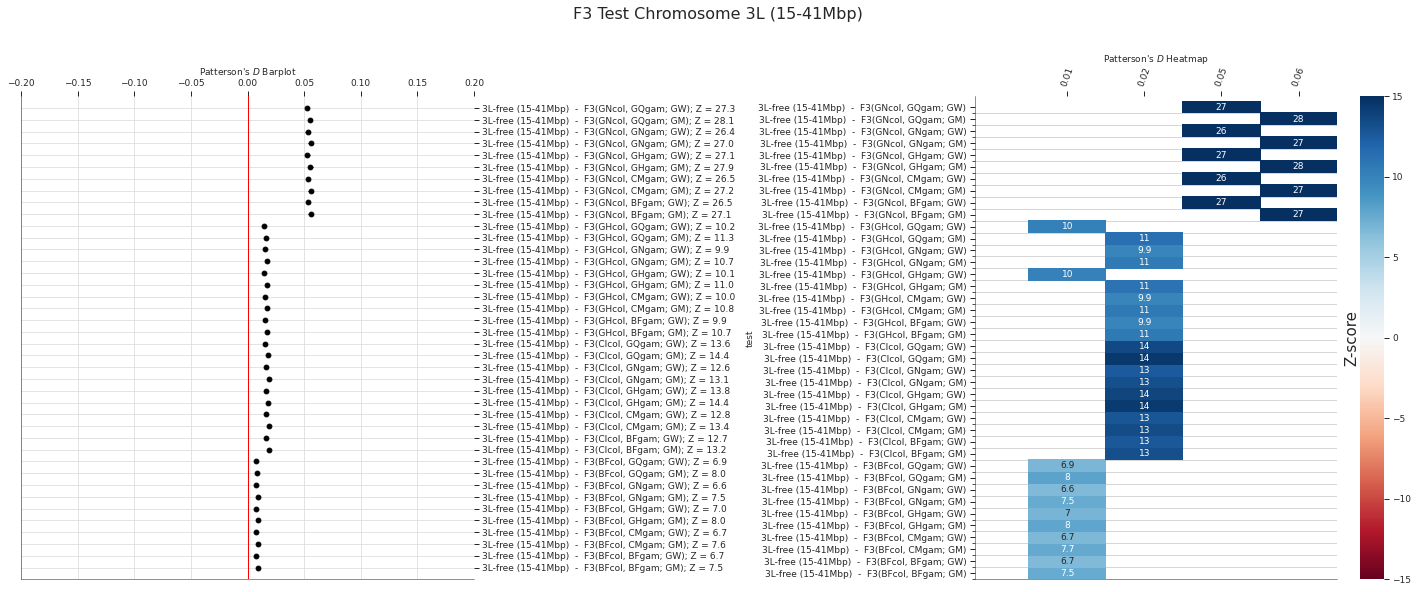

In [27]:
tbl_d_plot(f3_test, 'F3 Test Chromosome 3L (15-41Mbp)')

-------------------------------------------------------
## F3 stat on 3R

In [15]:
ac_3R_24 = count_alleles_pos('3R', 1, 24_000_000)
ac_3R_24

<AlleleCountsChunkedTable shape=(5760020,) dtype=[('AOcol', '<i4', (2,)), ('BFcol', '<i4', (2,)), ('BFgam', '<i4', (2,)), ('CIcol', '<i4', (2,)), ('CMgam', '<i4', (2,)), ('FRgam', '<i4', (2,)), ('GAgam', '<i4', (2,)), ('GHcol', '<i4', (2,)), ('GHgam', '<i4', (2,)), ('GM', '<i4', (2,)), ('GNcol', '<i4', (2,)), ('GNgam', '<i4', (2,)), ('GQgam', '<i4', (2,)), ('GW', '<i4', (2,)), ('KE', '<i4', (2,)), ('UGgam', '<i4', (2,))]
   nbytes=703.1M
   values=builtins.dict>

In [16]:
loc = (allel.SortedIndex(callset_biallel['3R']["variants/POS"])).locate_range(1, 24_000_000)
loc

slice(0, 5760020, None)

In [17]:
ac_out_3R_24 = {pop: calldata_out['3R'][pop][loc] for pop in out_species}

In [18]:
chromosomes = ['3R']

In [11]:
ac_cache = dict()

def load_ac(pop):
    if (pop) in ac_cache:
        return ac_cache[pop]
    else:
        if pop in out_species:
            ac = allel.AlleleCountsChunkedArray(ac_out_3R_24[pop])
        else:
            ac = ac_3R_24[pop]
            ac_cache[pop] = ac
        return ac
    
fourpop_cache = dict()

In [12]:
#this is the function that perform the test
def f3_analysis(A, B, C, blen=100000, plot=False, ax=None):
    
    key = (A, B, C, blen)
    if key in fourpop_cache:
        # re-use from cache
        d, d_se, d_z, d_vb, d_vj = fourpop_cache[key]
        
    else:
        # load allele counts
        aca = load_ac(A)
        acb = load_ac(B)
        acc = load_ac(C)

        # run D test
        d, d_se, d_z, d_vb, d_vj = allel.average_patterson_f3(aca, acb, acc, blen=blen)
        
        # cache for re-use
        fourpop_cache[key] = d, d_se, d_z, d_vb, d_vj
    
    return d, d_se, d_z, d_vb, d_vj

#this is the function that give me to display multiple tests on a table
def f3_analyses(As, Bs, Cs, blen=100000):
    
    # normalise inputs
    if not isinstance(As, (list, tuple)):
        As = [As]
    if not isinstance(Bs, (list, tuple)):
        Bs = [Bs]
    if not isinstance(Cs, (list, tuple)):
        Cs = [Cs]
        
    # setup output table    
    tbl = [['test', 'D', 'SE', 'Z']]
    for A in As:
        for B in Bs:
            if A != B:
                for C in Cs:
                    if C != B:
                            d, d_se, d_z, _, _ = f3_analysis(A, B, C, blen=blen)
                            test = '3R (1-24Mbp)  -  F3(%s, %s; %s)' % (A, B, C)
                            row = [test, d, d_se, d_z]
                            tbl += [row]
    
    return tbl

def tbl_display(tbl):
        # display results
    (etl
     .wrap(tbl)
     .interpolate('D', '%.3f')
     .interpolate('SE', '%.4f')
     .interpolate('Z', '%.1f')
     .displayall(index_header=False, 
                 tr_style=lambda row: 'background-color: %s' % ('#afa' if float(row.Z) > 5 else '#aaf' if float(row.Z) < -5 else 'white')))
    

    
def tbl_f3_plot(table, title):
    # plot
    tbl = etl.wrap(table).sort('test')
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, tbl.nrows()*.2))
    
    ## First Plot - Bar Plot
    x = tbl.values('D').array()
    y = np.arange(tbl.nrows())
    ax1.axvline(0, color='r', lw=1)
    xerr = tbl.values('SE').array()
    ax1.errorbar(x, y, xerr=xerr, fmt='o', lw=1, color='k', mew=1, mfc='k')
    ax1.set_yticks(y)
    ylbls = ['%s; Z = %.1f' % (v.test, v.Z) for v in tbl.records()]
    ax1.set_yticklabels(ylbls)
    ax1.yaxis.tick_right()
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top')
    ax1.set_xlim(-.2,.2)
    ax1.set_ylim(-1, y.size)
    ax1.grid(axis='both', color='#dddddd')
    ax1.set_xlabel("Patterson's $D$ Barplot")
    fig.suptitle('%s' % (title), y=1.02, fontsize=16)

    ## Second plot - Heatmap
    results = etl.todataframe(tbl)
    df1 = results[['test', 'D','Z']].round(2)
    heatmap1_data = pd.pivot_table(df1, values='Z', 
                     index=['test'], 
                     columns='D')
    lm = sns.heatmap(heatmap1_data, cmap="RdBu", vmin=15, vmax=-15, annot=True)
    ax2 = lm.axes
    ax2.set_xlim(-.7)
    ax2.set_ylim(40.4)
    ax2.xaxis.set_label_position('top')
    ax2.xaxis.tick_top()
    plt.xticks(rotation=70)
    ax2.set_xlabel("Patterson's $D$ Heatmap")
    ax2.invert_yaxis()
    plt.text(1.02, 0.5, 'Z-score', {'fontsize': 15},
             horizontalalignment='left',
             verticalalignment='center',
             rotation=90,
             clip_on=False,
             transform=plt.gca().transAxes)

    ax2.grid(False, 'major')
    ax2.grid(True, 'minor')
    ax2.set_yticks([t - 0.5 for t in ax2.get_yticks()], minor=True)
    sns.despine()
    fig.tight_layout()
    plt.show()  

In [13]:
A = an_col
B = an_gam
C = an_fw
f3_test = f3_analyses(A, B, C)

In [14]:
tbl_display(f3_test)

test,D,SE,Z
"3R (1-24Mbp) - F3(BFcol, GHgam; GM)",0.012,0.0076,1.5
"3R (1-24Mbp) - F3(BFcol, GHgam; GW)",0.010,0.0065,1.5
"3R (1-24Mbp) - F3(BFcol, CMgam; GM)",0.012,0.0076,1.6
"3R (1-24Mbp) - F3(BFcol, CMgam; GW)",0.010,0.0065,1.5
"3R (1-24Mbp) - F3(BFcol, BFgam; GM)",0.012,0.0076,1.6
"3R (1-24Mbp) - F3(BFcol, BFgam; GW)",0.010,0.0065,1.5
"3R (1-24Mbp) - F3(BFcol, GNgam; GM)",0.012,0.0076,1.6
"3R (1-24Mbp) - F3(BFcol, GNgam; GW)",0.010,0.0065,1.5
"3R (1-24Mbp) - F3(BFcol, GQgam; GM)",0.011,0.0071,1.6
"3R (1-24Mbp) - F3(BFcol, GQgam; GW)",0.009,0.0061,1.5


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


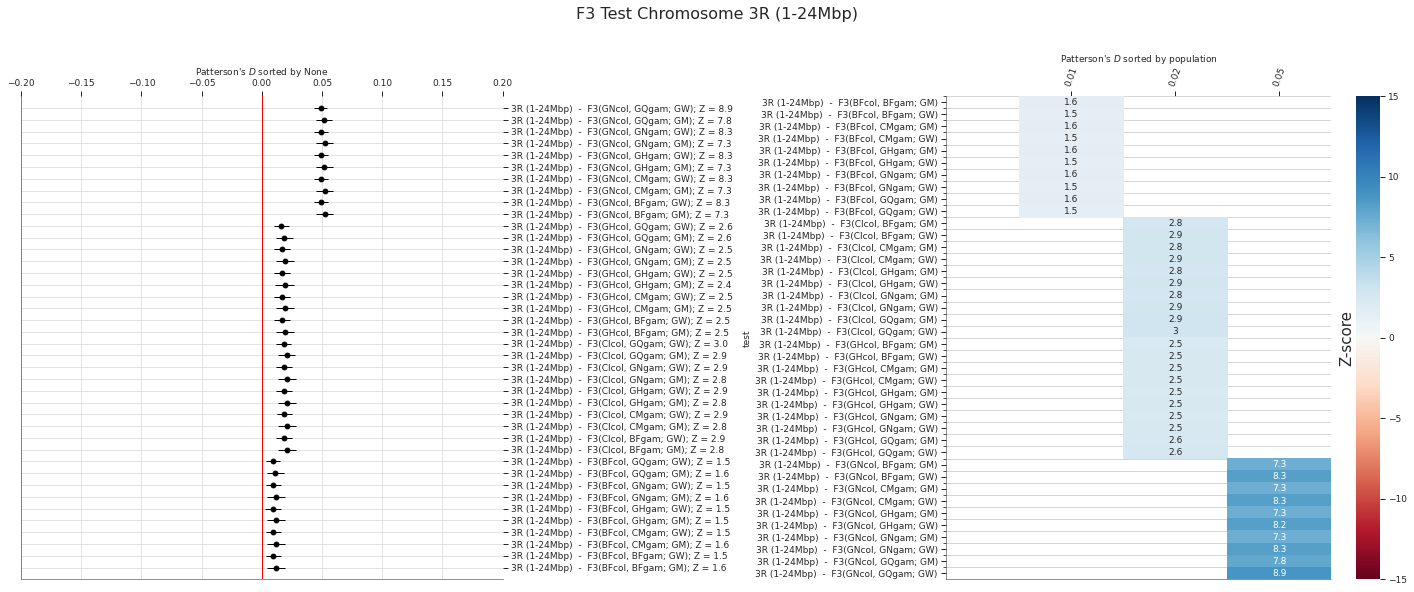

In [15]:
tbl_d_plot(f3_test, 'F3 Test Chromosome 3R (1-24Mbp)')

In [16]:
A = an_gam
B = an_col
C = an_fw
f3_test = f3_analyses(A, B, C)

In [17]:
tbl_display(f3_test)

test,D,SE,Z
"3R (1-24Mbp) - F3(GHgam, BFcol; GM)",0.016,0.0024,6.7
"3R (1-24Mbp) - F3(GHgam, BFcol; GW)",0.019,0.0035,5.3
"3R (1-24Mbp) - F3(GHgam, GNcol; GM)",0.019,0.0025,7.8
"3R (1-24Mbp) - F3(GHgam, GNcol; GW)",0.022,0.0035,6.2
"3R (1-24Mbp) - F3(GHgam, CIcol; GM)",0.018,0.0025,7.2
"3R (1-24Mbp) - F3(GHgam, CIcol; GW)",0.021,0.0036,5.8
"3R (1-24Mbp) - F3(GHgam, GHcol; GM)",0.018,0.0025,7.3
"3R (1-24Mbp) - F3(GHgam, GHcol; GW)",0.021,0.0036,5.8
"3R (1-24Mbp) - F3(CMgam, BFcol; GM)",0.013,0.0023,5.5
"3R (1-24Mbp) - F3(CMgam, BFcol; GW)",0.015,0.0034,4.4


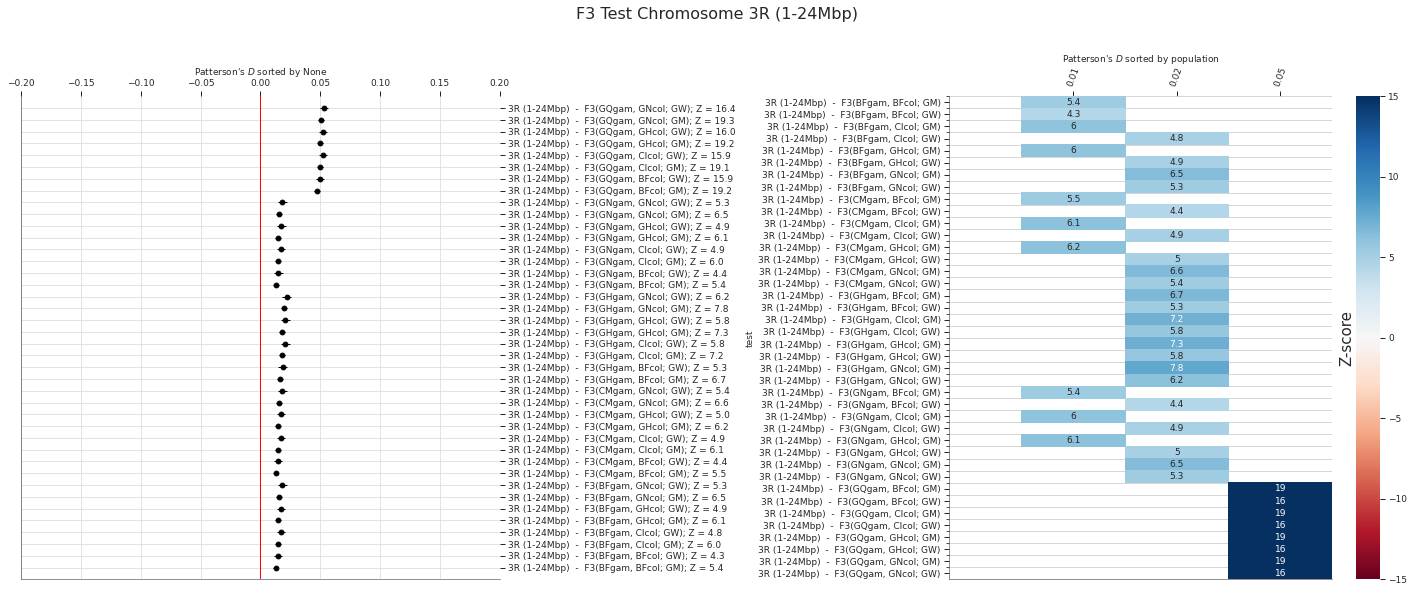

In [18]:
tbl_d_plot(f3_test, 'F3 Test Chromosome 3R (1-24Mbp)')

------------------------------------------------------------------

In [19]:
ac_out_3R_24 + ac_out_3L_free

TypeError: unsupported operand type(s) for +: 'dict' and 'dict'

In [ ]:
ac_3L_free + ac_3R_24